# About Dataset
**The ultimate Soccer database for data analysis and machine learning
What you get:**

- +25,000 matches
- +10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates - - Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matches
- *16th Oct 2016: New table containing teams' attributes from FIFA !


Improving the dataset:

You will notice that some players are missing from the lineup (NULL values). This is because I have not been able to source their attributes from FIFA. This will be fixed overtime as the crawling algorithm is being improved. The dataset will also be expanded to include international games, national cups, Champion's League and Europa League. Please ask me if you're after a specific tournament.


Probabilities vs Odds

When running a multi-class classifier like SVM you could also output a probability estimate and compare it to the betting odds. Have a look at your variance vs odds and see for what games you had very different predictions.


## Business interest
Soccer is the most popular sport in the world with millions of viewers and players. People like to bet on the game result and betting companies have interest to let them bet. But how can companies can get advantage by using data analyses?
- Which leagues are in which countries?
- Which leagues score the most/fewest goals?
- Is there such a thing as home advantage which can be added to prediction models?

- Betting companies have interest to predict the end of the game and set coefficient for people to bet.
Can we make a model which predicts the  winning team of the match?

In [5]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score, precision_score, mean_squared_error
from math import sqrt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import  confusion_matrix


In [6]:
path = '/kaggle/input/ultimate-25k-matches-football-database-european/database.sqlite'
con = sqlite3.connect(path)

In [7]:
table = pd.read_sql('''

SELECT 
* 
FROM sqlite_master 
WHERE type = 'table' ;

 ''',con)
table

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [8]:
match = pd.read_sql_query('''SELECT * FROM match''', con)
match = match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4'
                    , 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8'
                    , 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1'
                    , 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5'
                    , 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9'
                    , 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2'
                    , 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6'
                    , 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10'
                    , 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3'
                    , 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7'
                    , 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11'], axis=1)
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [9]:
league = pd.read_sql_query('SELECT * FROM league', con)
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [10]:
country = pd.read_sql_query('SELECT * FROM country', con)
country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [11]:
team = pd.read_sql_query('SELECT * FROM team', con)
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [12]:
team_attributes = pd.read_sql_query('''SELECT * FROM team_attributes
                                        ''', con)
team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [13]:
player = pd.read_sql_query('SELECT * FROM player', con)
player

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154
...,...,...,...,...,...,...,...
11055,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168
11056,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176
11057,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154
11058,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172


In [14]:
player_attributes = pd.read_sql_query('SELECT * FROM player_attributes', con)
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [15]:
sqlite_sequence = pd.read_sql_query('SELECT * FROM sqlite_sequence', con)
sqlite_sequence

,name,seq
0,Team,103916
1,Country,51958
2,League,51958
3,Match,51958
4,Player,11075
5,Player_Attributes,183978
6,Team_Attributes,1458


## Data Joining

### Which leagues are in which countries?

In [16]:
leagues_and_countries = pd.read_sql_query('''   SELECT 
                                                
                                                c.name AS country
                                                , substr(l.name, length(c.name)+1, length(l.name)) As league

                                                FROM league AS l
                                                
                                                JOIN country AS c
                                                ON l.country_id = c.id

                                                ''', con)
leagues_and_countries

,country,league
0,Belgium,Jupiler League
1,England,Premier League
2,France,Ligue 1
3,Germany,1. Bundesliga
4,Italy,Serie A
5,Netherlands,Eredivisie
6,Poland,Ekstraklasa
7,Portugal,Liga ZON Sagres
8,Scotland,Premier League
9,Spain,LIGA BBVA


### Which leagues score the most/fewest goals?

In [17]:
leagues_most_goals = pd.read_sql_query('''  SELECT 
                                                
                                            c.name AS country
                                            , substr(l.name, length(c.name)+1, length(l.name)) As league
                                            , m.home_team_goal + m.away_team_goal AS goals
                                            
                                            FROM league AS l
                                            
                                            JOIN country AS c
                                            ON l.country_id = c.id

                                            JOIN match AS m
                                            ON l.country_id = m.country_id

                                            ''', con)


leagues_most_goals = leagues_most_goals.groupby(['country', 'league']).agg(
    sum_goals = ("goals", "sum"),
    mean_goals = ("goals", "mean"),
    std_goals = ("goals", "std"), 
    count_of_game = ("goals", "count")

).reset_index().sort_values(by=['mean_goals'])
leagues_most_goals

,country,league,sum_goals,mean_goals,std_goals,count_of_game
6,Poland,Ekstraklasa,4656,2.425000,1.540355,1920
2,France,Ligue 1,7427,2.443092,1.551799,3040
7,Portugal,Liga ZON Sagres,5201,2.534600,1.637348,2052
4,Italy,Serie A,7895,2.616838,1.640327,3017
8,Scotland,Premier League,4804,2.633772,1.644379,1824
1,England,Premier League,8240,2.710526,1.691127,3040
9,Spain,LIGA BBVA,8412,2.767105,1.731111,3040
0,Belgium,Jupiler League,4841,2.801505,1.656507,1728
3,Germany,1. Bundesliga,7103,2.901552,1.704974,2448
10,Switzerland,Super League,4166,2.929677,1.717765,1422


- By counting total goals in the leagues, the **fewest** goals have Switzerland Super League and **most** goals have Spain LIGA BBVA.
- By looking at mean goals during the game, the **fewest** goals have Poland Ekstraklasa and **most** goals have Netherlands Eredivisie	.

### Is there such a thing as home advantage?

In [18]:
home_advantage_count = pd.read_sql_query('''      SELECT 
                                            result.win AS win
                                            , SUM(result.score) AS count

                                            FROM (
                                                SELECT 
                                                    
                                                CASE 
                                                    WHEN m.home_team_goal > m.away_team_goal THEN 'home_win'
                                                    WHEN m.home_team_goal < m.away_team_goal THEN 'away_win'
                                                    ELSE 'equal'
                                                END AS win
                                                , 1 AS score
                                                
                                                FROM match AS m ) result
                                            GROUP BY result.win

                                            ''', con)
home_advantage_count

,win,count
0,away_win,7466
1,equal,6596
2,home_win,11917


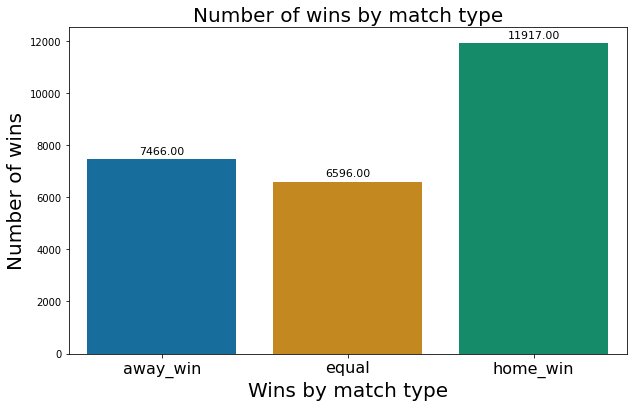

In [19]:
fig = plt.figure(figsize = (10,6))
ax = sns.barplot(x = 'win', y = 'count', data = home_advantage_count, palette='colorblind')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=16)
ax.set_xlabel("Wins by match type", fontsize = 20)
ax.set_ylabel("Number of wins", fontsize = 20)
ax.set_title("Number of wins by match type", fontsize = 20)
plt.show()

From the graph we see that match at home has advantages and gives more chance to win.

### Mean of winning home game

In [20]:
home_advantage = pd.read_sql_query('''      SELECT 

                                            CASE 
                                                WHEN m.home_team_goal > m.away_team_goal THEN 1
                                                ELSE 0
                                            END AS home_win
                                            , CASE 
                                                WHEN m.home_team_goal < m.away_team_goal THEN 1
                                                ELSE 0
                                            END AS away_win
                                            , CASE 
                                                WHEN m.home_team_goal = m.away_team_goal THEN 1
                                                ELSE 0
                                            END AS equal
                                            FROM match AS m 
                                            

                                            ''', con)


Let's find mean game won at home with 95% confidence.

In [23]:
mean = home_advantage.home_win.mean()
n = len(home_advantage)
sd = home_advantage.home_win.std()
(mean, n)

(0.45871665576042187, 25979)

In [24]:
tstar = 1.96
standart_error = sd/np.sqrt(n)
standart_error

0.003091588835745996

In [25]:
lcb = mean - tstar * standart_error
ucb = mean + tstar * standart_error
(lcb, ucb)

(0.4526571416423597, 0.464776169878484)

Check confidence interval by formula

In [26]:
sm.stats.DescrStatsW(home_advantage.home_win).zconfint_mean()

(0.4526572529873536, 0.46477605853349013)

The mean of home match win is between (0.4526572529873536, 0.46477605853349013)

Z test

- h0 mean probability of home game is 0.453
- h1 mean probability of home game is not 0.453

In [27]:
sm.stats.ztest(home_advantage.home_win, value = 0.453)

(1.8490996261611323, 0.06444342836775803)

In [28]:
sm.stats.ztest(home_advantage.home_win, value = 0.453, alternative='larger')

(1.8490996261611323, 0.032221714183879015)

In [29]:
sm.stats.ztest(home_advantage.home_win, value = 0.453, alternative='smaller')

(1.8490996261611323, 0.967778285816121)

- h0 is not rejected,
- h1 is not rejected.

### Let's prepare data for predicting goals per team

In [30]:
team_goals = pd.read_sql_query('''        SELECT 
                                            tt.team_long_name AS opponent_team
                                            , query.*
                                             
                                            FROM
                                            
                                            (   SELECT 
                                                        
                                                m.date
                                                , t.team_long_name AS team_name
                                                , CASE 
                                                    WHEN t.team_api_id = m.home_team_api_id THEN m.home_team_goal - m.away_team_goal  
                                                    WHEN t.team_api_id = m.away_team_api_id THEN m.away_team_goal - m.home_team_goal 
                                                    WHEN m.home_team_goal = m.away_team_goal THEN 0
                                                END AS game_result
                                                , CASE 
                                                    WHEN t.team_api_id = m.home_team_api_id THEN 1
                                                    ELSE 0
                                                END AS home_game
                                                , CASE 
                                                    WHEN t.team_api_id = m.home_team_api_id THEN m.away_team_api_id
                                                    ELSE m.home_team_api_id
                                                END AS opponent_id
                                                , ta.buildUpPlaySpeed AS buildUpPlaySpeed
                                                , ta.buildUpPlayDribblingClass AS buildUpPlayDribblingClass
                                                , ta.buildUpPlayPassing AS buildUpPlayPassing
                                                , ta.buildUpPlayPositioningClass AS buildUpPlayPositioningClass
                                                , ta.chanceCreationPassing AS chanceCreationPassing
                                                , ta.chanceCreationCrossing AS chanceCreationCrossing
                                                , ta.chanceCreationShooting AS chanceCreationShooting
                                                , ta.chanceCreationPositioningClass AS chanceCreationPositioningClass
                                                , ta.defencePressure AS defencePressure
                                                , ta.defenceAggression AS defenceAggression
                                                , ta.defenceTeamWidth AS defenceTeamWidth
                                                , ta.defenceDefenderLineClass AS defenceDefenderLineClass

                                                FROM match AS m

                                                JOIN team AS t
                                                ON t.team_api_id = ta.team_api_id


                                                LEFT JOIN team_attributes AS ta
                                                ON 
                                                    (ta.id = (
                                                        SELECT taa.id
                                                        FROM team_attributes AS taa
                                                        WHERE taa.team_api_id = m.home_team_api_id
                                                        ORDER BY taa.date
                                                        LIMIT 1
                                                        )
                                                    OR
                                                    
                                                    ta.id = (
                                                        SELECT taa.id
                                                        FROM team_attributes AS taa
                                                        WHERE taa.team_api_id = m.away_team_api_id
                                                        ORDER BY taa.date
                                                        LIMIT 1
                                                        )
                                                    )
                                                    AND (cast(strftime('%Y',m.date) as decimal) ) <= cast(strftime('%Y',ta.date) as decimal)
                                            ) AS query
                                            
                                            JOIN team AS tt
                                            ON tt.team_api_id = query.opponent_id
                                            
                                            ''', con)
team_goals = team_goals.drop(['opponent_id'], axis=1)
team_goals['date'] = pd.to_datetime(team_goals['date'])               
team_goals.head(5)

,opponent_team,date,team_name,game_result,home_game,buildUpPlaySpeed,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass
0,KRC Genk,2008-08-17,Beerschot AC,0,0,35,Little,35,Organised,45,40,50,Organised,70,70,70,Cover
1,Beerschot AC,2008-08-17,KRC Genk,0,1,45,Little,45,Organised,50,35,60,Organised,70,65,70,Cover
2,SV Zulte-Waregem,2008-08-16,Sporting Lokeren,0,0,60,Little,60,Organised,50,40,50,Organised,65,65,70,Cover
3,Sporting Lokeren,2008-08-16,SV Zulte-Waregem,0,1,65,Little,60,Organised,60,40,50,Organised,70,60,70,Cover
4,KSV Cercle Brugge,2008-08-16,RSC Anderlecht,3,0,50,Little,35,Organised,70,50,60,Organised,70,50,70,Cover


Let's plot the correlation function

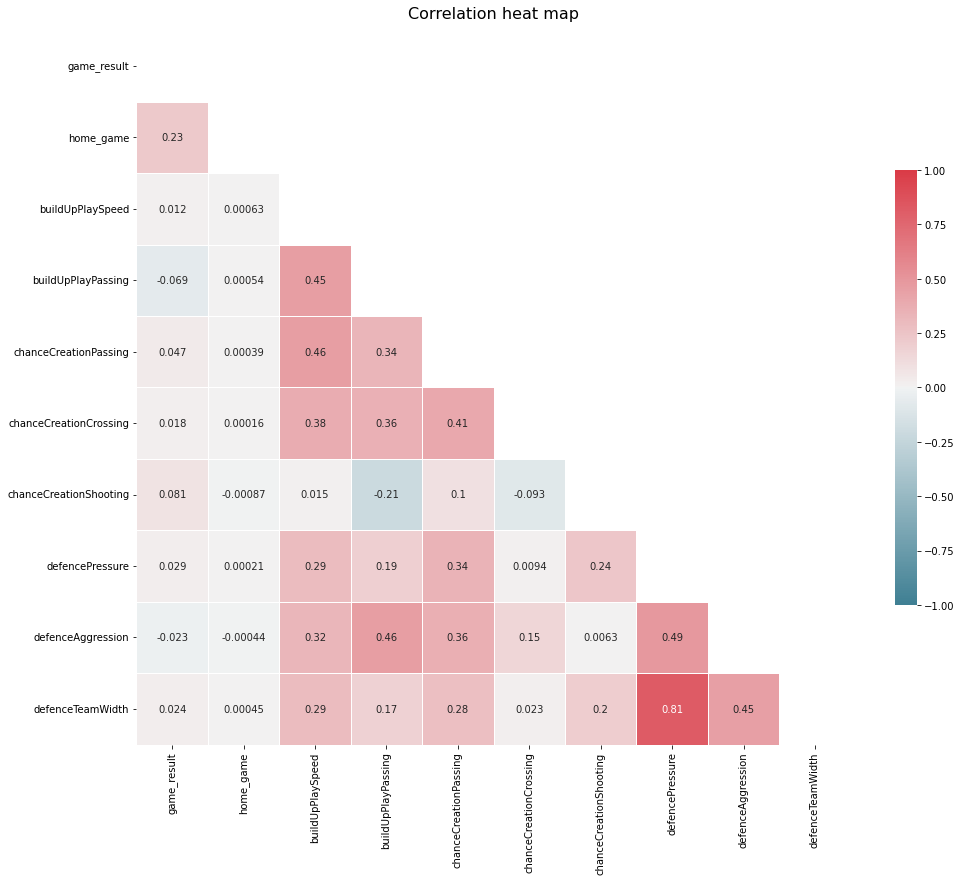

In [31]:
corr = team_goals.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

heatmap.set_title(
    "Correlation heat map",
    fontdict={"fontsize": 16},
    pad=12,
)
plt.xlabel("")
plt.ylabel("");

From the correlation graph we see that goal column correlates with home_game column by 0.15.

In [32]:
team_goals.isnull().sum()


opponent_team                     0
date                              0
team_name                         0
game_result                       0
home_game                         0
buildUpPlaySpeed                  0
buildUpPlayDribblingClass         0
buildUpPlayPassing                0
buildUpPlayPositioningClass       0
chanceCreationPassing             0
chanceCreationCrossing            0
chanceCreationShooting            0
chanceCreationPositioningClass    0
defencePressure                   0
defenceAggression                 0
defenceTeamWidth                  0
defenceDefenderLineClass          0
dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


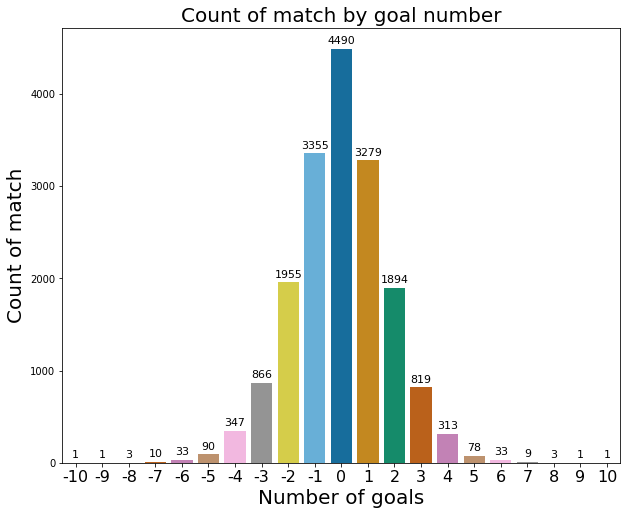

In [33]:

fig = plt.figure(figsize = (10,8))
ax = sns.countplot(team_goals['game_result'], palette='colorblind')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=16)
ax.set_xlabel("Number of goals", fontsize = 20)
ax.set_ylabel("Count of match", fontsize = 20)
ax.set_title("Count of match by goal number", fontsize = 20)
plt.show()

### Linear model for goal difference prediction
Lets devide target column 'goal' from other data.

In [34]:
train_data_goals, test_data_goals = train_test_split(team_goals, test_size=0.2, random_state=1)

In [35]:
numerical_features_goals = [
    "buildUpPlaySpeed",
    "buildUpPlayPassing", 
    "chanceCreationPassing",
    "chanceCreationCrossing",
    "chanceCreationShooting", 
    "defencePressure", 
    "defenceAggression", 
    "defenceTeamWidth"
]
categorical_features_goals = [
    "opponent_team",
    "team_name",
    "home_game",
    "buildUpPlayDribblingClass",
    "buildUpPlayPositioningClass", 
    "chanceCreationPositioningClass", 
    "defenceDefenderLineClass"
]
label_column_goals = "game_result"

### Base line
Model always predicts 0 goal.

In [36]:
alwaysOne = np.empty(3517)
alwaysOne.fill(0)
alwaysOne.shape

(3517,)

In [37]:
y_test_goals = test_data_goals[label_column_goals].to_numpy()
y_test_goals.shape

(3517,)

In [38]:
print("Base line scores:")
print('Mean squared error: ' + str(mean_squared_error(alwaysOne, y_test_goals)))
print('Root mean squared error: ' + str(sqrt(mean_squared_error( y_test_goals, alwaysOne))))


Base line scores:
Mean squared error: 3.107477964174012
Root mean squared error: 1.7628040061714212


### Goals prediction model 

In [39]:
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant", add_indicator=True)),
        (
            "categorical_encoder",
            OneHotEncoder(handle_unknown='ignore'),
        ),
    ]
)

numerical_transformer = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="constant", add_indicator=True)),
        (
            "numerical_scaler",
            StandardScaler(),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features_goals,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features_goals,
        ),
    ]
)

In [40]:
linear_model = LinearRegression()

Creating data preprocessing pipeline

In [41]:
linear_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", linear_model)])

In [42]:
_ = linear_pipe.fit(
    train_data_goals[numerical_features_goals + categorical_features_goals], train_data_goals[label_column_goals]
)

In [43]:
y_pred_goals = linear_pipe.predict(test_data_goals[numerical_features_goals + categorical_features_goals])

In [44]:
y_test_goals = test_data_goals[label_column_goals].to_numpy()

Function to print results

In [45]:
def fit_and_print( y_pred, y_test):

    print('Test mean squared error: ' + str(mean_squared_error(y_pred, y_test)))
    print('Test root mean squared error: ' + str(sqrt(mean_squared_error( y_test, y_pred))))

In [46]:
'''model with linear regression'''
fit_and_print(y_pred_goals, y_test_goals)

Test mean squared error: 2.4112661364845605
Test root mean squared error: 1.5528252111826883


Base line scores:
- Mean squared error: 3.107477964174012
- Root mean squared error: 1.7628040061714212


Base line scores was worse, so we created a model which is better than always guess 0 goal per match

### Can we predict which team will win the match?

In [47]:
win_the_game = pd.read_sql_query('''SELECT 
                                    tt.team_long_name AS opponent_team
                                    , query.*

                                    FROM

                                    (   SELECT 

                                        m.date
                                        , t.team_long_name AS team_name
                                        , CASE 
                                            WHEN t.team_api_id = m.home_team_api_id AND m.home_team_goal > m.away_team_goal THEN 'won'
                                            WHEN t.team_api_id = m.home_team_api_id AND m.home_team_goal < m.away_team_goal THEN 'lost'
                                            WHEN t.team_api_id = m.away_team_api_id AND m.home_team_goal < m.away_team_goal THEN 'won'
                                            WHEN t.team_api_id = m.away_team_api_id AND m.home_team_goal > m.away_team_goal THEN 'lost'
                                            WHEN m.home_team_goal = m.away_team_goal THEN 'draw'
                                        END AS game_result
                                        , CASE 
                                            WHEN t.team_api_id = m.home_team_api_id THEN 1
                                            ELSE 0
                                        END AS home_game
                                        , CASE 
                                            WHEN t.team_api_id = m.home_team_api_id THEN m.away_team_api_id
                                            ELSE m.home_team_api_id
                                        END AS opponent_id
                                        , ta.buildUpPlaySpeed AS buildUpPlaySpeed
                                        , ta.buildUpPlayDribblingClass AS buildUpPlayDribblingClass
                                        , ta.buildUpPlayPassing AS buildUpPlayPassing
                                        , ta.buildUpPlayPositioningClass AS buildUpPlayPositioningClass
                                        , ta.chanceCreationPassing AS chanceCreationPassing
                                        , ta.chanceCreationCrossing AS chanceCreationCrossing
                                        , ta.chanceCreationShooting AS chanceCreationShooting
                                        , ta.chanceCreationPositioningClass AS chanceCreationPositioningClass
                                        , ta.defencePressure AS defencePressure
                                        , ta.defenceAggression AS defenceAggression
                                        , ta.defenceTeamWidth AS defenceTeamWidth
                                        , ta.defenceDefenderLineClass AS defenceDefenderLineClass

                                        FROM match AS m

                                        JOIN team AS t
                                        ON t.team_api_id = ta.team_api_id


                                        LEFT JOIN team_attributes AS ta
                                        ON 
                                            (ta.id = (
                                                SELECT taa.id
                                                FROM team_attributes AS taa
                                                WHERE taa.team_api_id = m.home_team_api_id
                                                ORDER BY taa.date
                                                LIMIT 1
                                                )
                                            OR

                                            ta.id = (
                                                SELECT taa.id
                                                FROM team_attributes AS taa
                                                WHERE taa.team_api_id = m.away_team_api_id
                                                ORDER BY taa.date
                                                LIMIT 1
                                                )
                                            )
                                            AND (cast(strftime('%Y',m.date) as decimal) ) <= cast(strftime('%Y',ta.date) as decimal)
                                    ) AS query

                                    JOIN team AS tt
                                    ON tt.team_api_id = query.opponent_id

                                            ''', con)
win_the_game = win_the_game.drop(['opponent_id'], axis=1)
win_the_game['date'] = pd.to_datetime(win_the_game['date'])               
win_the_game.head()

,opponent_team,date,team_name,game_result,home_game,buildUpPlaySpeed,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass
0,KRC Genk,2008-08-17,Beerschot AC,draw,0,35,Little,35,Organised,45,40,50,Organised,70,70,70,Cover
1,Beerschot AC,2008-08-17,KRC Genk,draw,1,45,Little,45,Organised,50,35,60,Organised,70,65,70,Cover
2,SV Zulte-Waregem,2008-08-16,Sporting Lokeren,draw,0,60,Little,60,Organised,50,40,50,Organised,65,65,70,Cover
3,Sporting Lokeren,2008-08-16,SV Zulte-Waregem,draw,1,65,Little,60,Organised,60,40,50,Organised,70,60,70,Cover
4,KSV Cercle Brugge,2008-08-16,RSC Anderlecht,won,0,50,Little,35,Organised,70,50,60,Organised,70,50,70,Cover


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


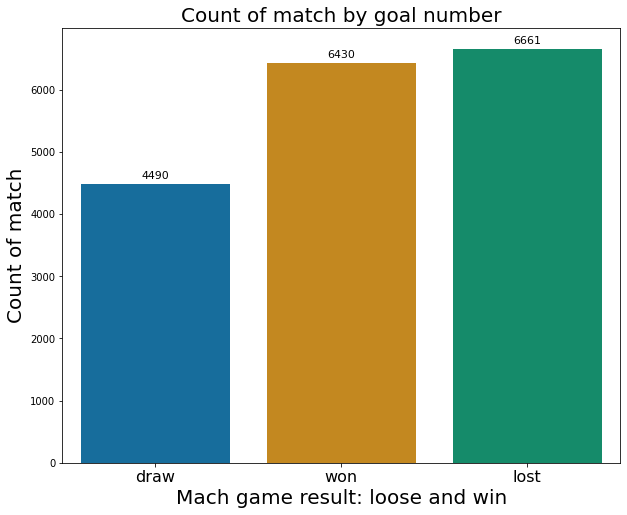

In [48]:
fig = plt.figure(figsize = (10,8))
ax = sns.countplot(win_the_game['game_result'], palette='colorblind')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=16)
ax.set_xlabel("Mach game result: loose and win", fontsize = 20)
ax.set_ylabel("Count of match", fontsize = 20)
ax.set_title("Count of match by goal number", fontsize = 20)

plt.show()

In [49]:
win_the_game.isnull().sum()

opponent_team                     0
date                              0
team_name                         0
game_result                       0
home_game                         0
buildUpPlaySpeed                  0
buildUpPlayDribblingClass         0
buildUpPlayPassing                0
buildUpPlayPositioningClass       0
chanceCreationPassing             0
chanceCreationCrossing            0
chanceCreationShooting            0
chanceCreationPositioningClass    0
defencePressure                   0
defenceAggression                 0
defenceTeamWidth                  0
defenceDefenderLineClass          0
dtype: int64

Separate target from dataframe

In [50]:
train_data, test_data = train_test_split(win_the_game, test_size=0.2, random_state=1)

In [51]:
numerical_features = [
    "buildUpPlaySpeed",
    "buildUpPlayPassing", 
    "chanceCreationPassing",
    "chanceCreationCrossing",
    "chanceCreationShooting", 
    "defencePressure", 
    "defenceAggression", 
    "defenceTeamWidth"
]
categorical_features = [
    "opponent_team",
    "team_name",
    "home_game",
    "buildUpPlayDribblingClass",
    "buildUpPlayPositioningClass", 
    "chanceCreationPositioningClass", 
    "defenceDefenderLineClass"
]
label_column = "game_result"

In [52]:
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant", add_indicator=True)),
        (
            "categorical_encoder",
            OneHotEncoder(handle_unknown='ignore'),
        ),
    ]
)

numerical_transformer = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="constant", add_indicator=True)),
        (
            "numerical_scaler",
            StandardScaler(),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
    ]
)

### Base Line

In [53]:
always_lost = np.empty(3517).astype('str')
always_lost.fill('lost')
always_lost.shape

(3517,)

In [54]:
y_test = test_data[label_column].to_numpy()
y_test.shape

(3517,)

In [55]:
print("Base line scores:")
print('Presision: ' + str(precision_score(always_lost, y_test, average='micro')))
print('Accuracy: ' + str(accuracy_score( y_test, always_lost)))

Base line scores:
Presision: 0.37844754051748647
Accuracy: 0.37844754051748647


In [56]:
def print_results( y_pred, y_test):
    print('Test accuracy: ' + str(accuracy_score( y_test,y_pred)))
    print('Test precision: ' + str(precision_score(  y_test, y_pred, average='micro')))

Creating Logistic regresion pipeline

In [57]:
model = LogisticRegression(solver='lbfgs', max_iter=5000)

In [58]:
pipe = Pipeline([("preprocessor", preprocessor),
                        ("model", model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['opponent_team', 'team_name',
                                                   'home_game',
                                                   'buildUpPlayDribblingClass',
                                                   'buildUpPlayPositioningClass',
                                                   'chanceCreati...
                                

In [59]:
_ = pipe.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

In [60]:
y_pred = pipe.predict(test_data[numerical_features + categorical_features])

In [61]:
print_results(y_pred, y_test)

Test accuracy: 0.5086721637759454
Test precision: 0.5086721637759454


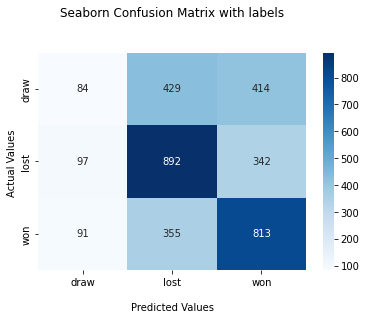

In [62]:
confm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confm, annot=True, cmap='Blues',fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['draw','lost', 'won'])
ax.yaxis.set_ticklabels(['draw','lost', 'won'])

plt.show()

# Conclusion



Data studio graphs https://datastudio.google.com/reporting/7f3af4cc-4f24-47d7-96cd-e3920e084987

Betting companies can have advantage if they use statistical analyses in their soccer match end result prediction. 

- In this analyses we saw that home team has advantage to win the game and this parameter and can be used in prediction model.
- In analyses was created to models which can predict the end goal difference for the teams.
- And another model which can predict end result of the game ( won, lost, draw).

# Improvements

This project can be imroved by including the feature importance into prediction models, which was not covered in this sprint material.